In [7]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
%matplotlib inline

import sys

sys.path.append("..")

import GanUtils as utils
import GaussianMixtureUtils as GMutils

sys.path.append("../DiscriminativeNN")

import DiscGaussianMixture5Layers as disc

sys.path.append("../GenerativeNN")

import GenGaussianMixture5Layers as gen

manualSeed = random.randint(1, 10000) # fix seed
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  9020


In [27]:
batchSize = 64
nz = 10
nc = 2 # Number of outputs
ndf = 100
ngf = 100
niter = 100
nElements = 1000
lr = 0.00005
beta1 = 0.5

c = 0.15

In [28]:
netD = torch.nn.Sequential(
    torch.nn.Linear(nc, ndf),
    torch.nn.ReLU(),
    torch.nn.Linear(ndf, ndf),
    torch.nn.ReLU(),
    torch.nn.Linear(ndf, 1)
)

In [29]:
criterion = nn.MSELoss()

# Might mistake here
input = torch.FloatTensor(batchSize, nc)
noise = torch.FloatTensor(batchSize, nz)
fake_data = torch.FloatTensor(batchSize, nc)
fixed_noise = torch.FloatTensor(batchSize, nz).normal_(0, 1)
label = torch.FloatTensor(batchSize)
real_label = 1
fake_label = 0

input = Variable(input)
label = Variable(label)
noise = Variable(noise)
fixed_noise = Variable(fixed_noise)
fake_data = Variable(fake_data)

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr = lr, betas = (beta1, 0.999))

reload(GMutils)

<module 'GaussianMixtureUtils' from '../GaussianMixtureUtils.pyc'>

[0/101][999/1000] Loss_D: 0.1047 / 0.1236 D(x): 0.6774 D(noise): 0.2406


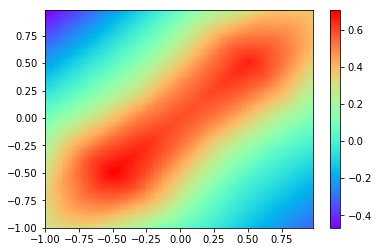

[1/101][999/1000] Loss_D: 0.0339 / 0.1183 D(x): 0.8164 D(noise): 0.2041


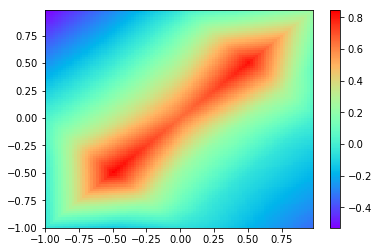

[2/101][999/1000] Loss_D: 0.0240 / 0.0813 D(x): 0.8458 D(noise): 0.1327


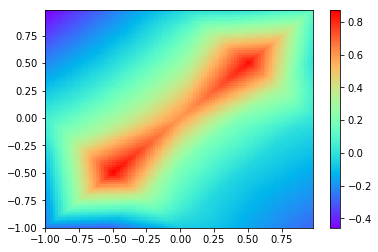

[3/101][999/1000] Loss_D: 0.0219 / 0.0889 D(x): 0.8531 D(noise): 0.1855


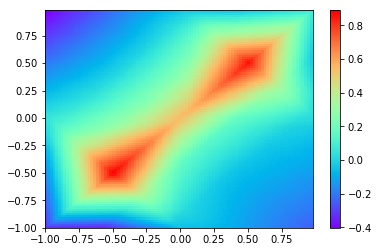

[4/101][999/1000] Loss_D: 0.0182 / 0.0663 D(x): 0.8666 D(noise): 0.1215


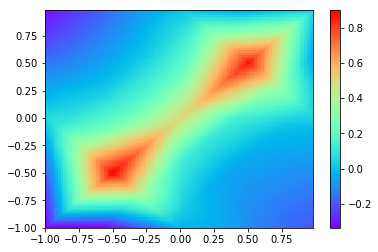

[5/101][999/1000] Loss_D: 0.0171 / 0.0857 D(x): 0.8700 D(noise): 0.1638


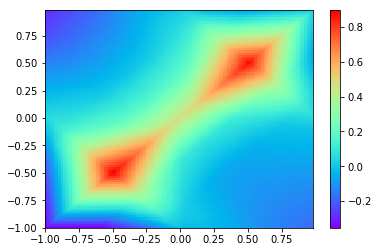

[6/101][999/1000] Loss_D: 0.0154 / 0.0729 D(x): 0.8768 D(noise): 0.1046


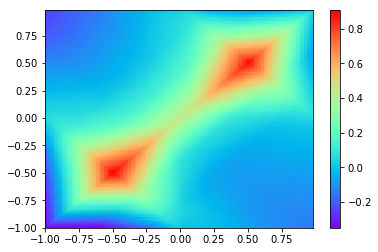

[7/101][999/1000] Loss_D: 0.0132 / 0.0696 D(x): 0.8860 D(noise): 0.1142


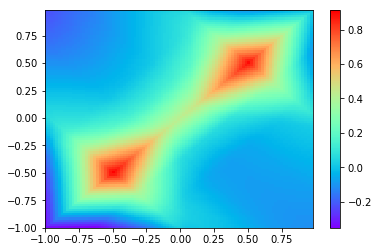

[8/101][999/1000] Loss_D: 0.0118 / 0.0505 D(x): 0.8928 D(noise): 0.0998


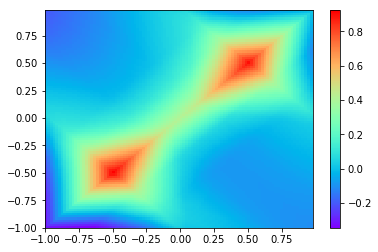

[9/101][999/1000] Loss_D: 0.0119 / 0.0680 D(x): 0.8920 D(noise): 0.1284


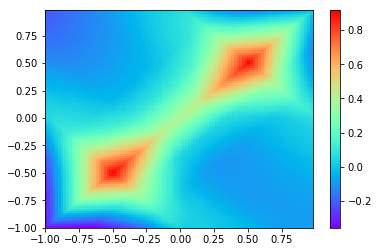

[10/101][999/1000] Loss_D: 0.0113 / 0.0504 D(x): 0.8956 D(noise): 0.0969


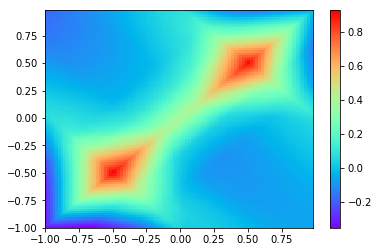

[11/101][999/1000] Loss_D: 0.0100 / 0.0705 D(x): 0.9011 D(noise): 0.1341


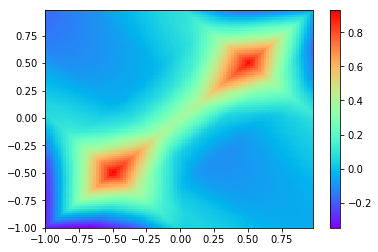

[12/101][999/1000] Loss_D: 0.0100 / 0.0749 D(x): 0.9018 D(noise): 0.1248


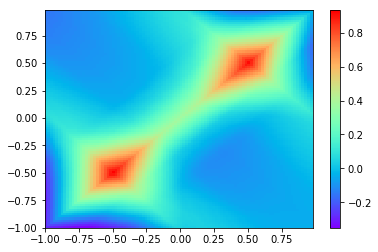

[13/101][999/1000] Loss_D: 0.0089 / 0.0806 D(x): 0.9066 D(noise): 0.1399


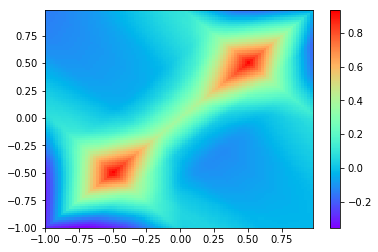

[14/101][999/1000] Loss_D: 0.0092 / 0.0516 D(x): 0.9059 D(noise): 0.0989


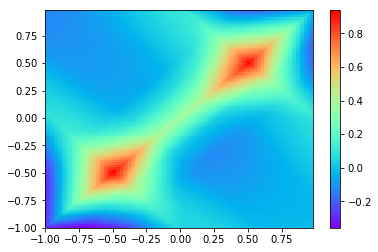

[15/101][999/1000] Loss_D: 0.0087 / 0.0884 D(x): 0.9080 D(noise): 0.1462


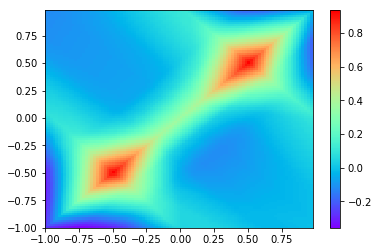

[16/101][999/1000] Loss_D: 0.0090 / 0.0563 D(x): 0.9076 D(noise): 0.1240


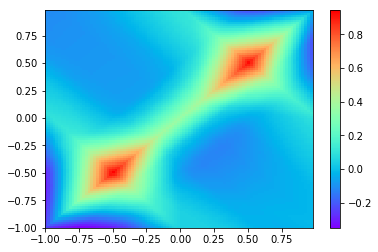

[17/101][999/1000] Loss_D: 0.0074 / 0.0648 D(x): 0.9163 D(noise): 0.1069


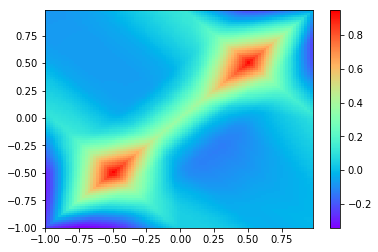

[18/101][999/1000] Loss_D: 0.0063 / 0.0589 D(x): 0.9224 D(noise): 0.0915


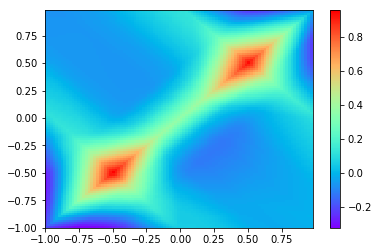

[19/101][999/1000] Loss_D: 0.0057 / 0.0212 D(x): 0.9264 D(noise): 0.0202


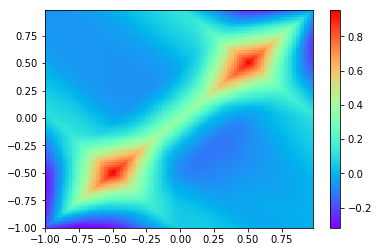

[20/101][999/1000] Loss_D: 0.0060 / 0.0376 D(x): 0.9244 D(noise): 0.0523


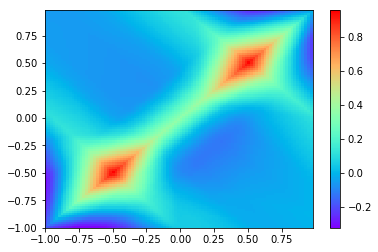

KeyboardInterrupt: 

In [30]:
for epoch in range(niter):
    for i in range(nElements):
        ############################
        # (1) Update D network
        ###########################
        # train with real
        netD.zero_grad()
            
        ## Real 
        real_cpu = GMutils.sample(batchSize)
        batch_size = real_cpu.size(0)
        input.data.resize_(real_cpu.size()).copy_(real_cpu)
            
        output_real = netD(input)
        D_real_mean = output_real.data.mean()
        
        label.data.fill_(real_label)
        errD_real = criterion(output_real, label)
        errD_real.backward()
        optimizerD.step()
        netD.zero_grad()
            
        ## Fake
        fake_data.data.resize_(batch_size, nc)
        fake_data.data.uniform_(-1, 1)
        output_fake = netD(fake_data)
        D_fake_mean = output_fake.data.mean()
            
        label.data.fill_(fake_label)
        errD_fake = criterion(output_fake, label)
        errD_fake.backward()
        optimizerD.step()
        
        ## Fake Generator approximation :
#         real_cpu = GMutils.sample_prime(batchSize)
#         batch_size = real_cpu.size(0)
#         input.data.resize_(real_cpu.size()).copy_(real_cpu)
            
#         output_real = netD(input)
#         D_real_mean = output_real.data.mean()
        
#         label.data.fill_(fake_label)
#         errD_real = criterion(output_real, label)
#         errD_real.backward()
#         optimizerD.step()
#         netD.zero_grad()
                        
        # Clip
        for p in netD.parameters():
            p.data.clamp_(-c, c)
        
    print('[%d/%d][%d/%d] Loss_D: %.4f / %.4f D(x): %.4f D(noise): %.4f'
              % (epoch, niter + 1, i, nElements,
                 errD_real.data[0], errD_fake.data[0], D_real_mean, D_fake_mean))
    GMutils.plot_discriminator(netD)

In [62]:
netG = torch.nn.Sequential(
    torch.nn.Linear(nz, ngf),
    torch.nn.ReLU(),
    torch.nn.Linear(ngf, ngf),
    torch.nn.ReLU(),
    torch.nn.Linear(ngf, nc),
    torch.nn.Tanh()
)

optimizerG = optim.RMSprop(netG.parameters(), lr = lr)

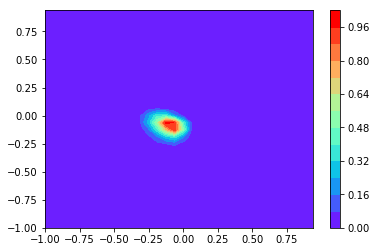

[0/101][99/100] Loss_G: -0.1111 D(G(z)): -0.0064


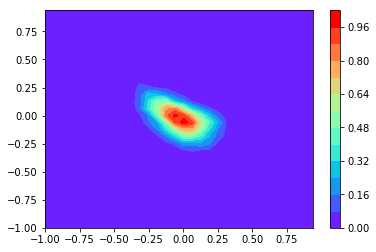

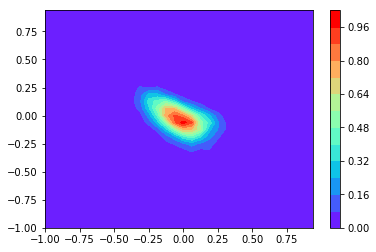

[1/101][99/100] Loss_G: -0.1350 D(G(z)): 0.0067


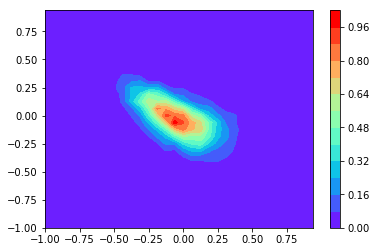

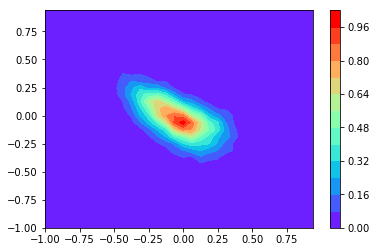

[2/101][99/100] Loss_G: -0.1839 D(G(z)): 0.0285


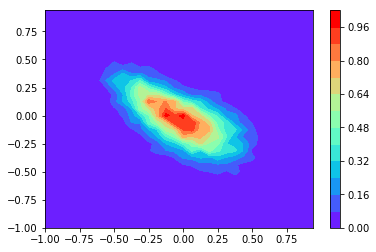

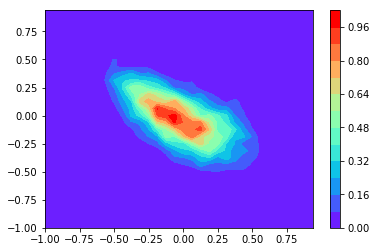

[3/101][99/100] Loss_G: -0.2206 D(G(z)): -0.0186


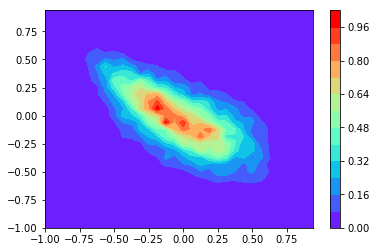

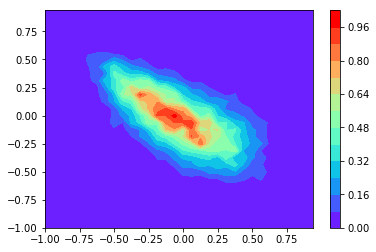

[4/101][99/100] Loss_G: -0.2748 D(G(z)): -0.0051


KeyboardInterrupt: 

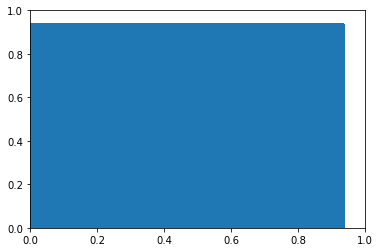

In [63]:
nElements = 100

for epoch in range(niter):
    GMutils.plot_heat_map(utils.sample_G(netG, nz, 10000))
    for i in range(nElements):
        ############################
        # (2) Update G network
        ###########################  
        netG.zero_grad()
        label.data.fill_(real_label) # fake labels are real for generator cost
        noise.data.normal_(0, 1)
        fake = netG(noise)
        #output = netD(fake)
        errG = - torch.std(fake) + fake.mean(0).norm()
        errG.backward()
        
        D_G_z2 = torch.mean(fake).data[0]
        optimizerG.step()
    print('[%d/%d][%d/%d] Loss_G: %.4f D(G(z)): %.4f'
              % (epoch, niter + 1, i, nElements, errG.data[0], D_G_z2))        
    GMutils.plot_heat_map(utils.sample_G(netG, nz, 10000))

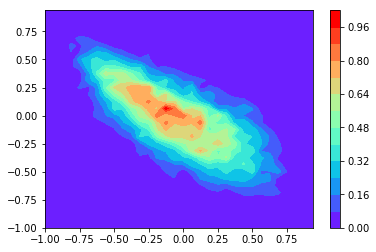

[0/101][99/100] Loss_G: -0.5711 D(G(z)): 0.5711


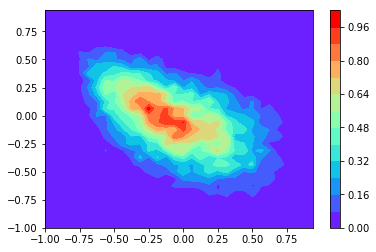

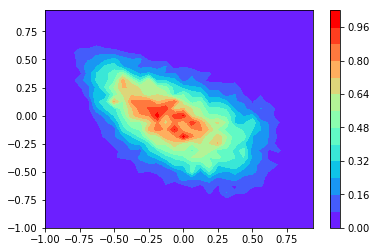

[1/101][99/100] Loss_G: -0.6475 D(G(z)): 0.6475


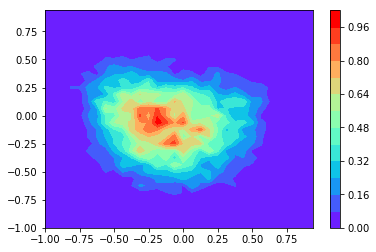

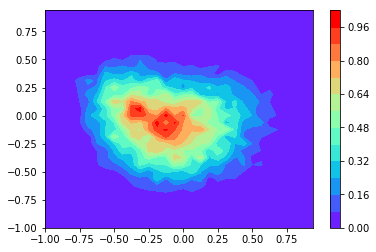

[2/101][99/100] Loss_G: -0.6796 D(G(z)): 0.6796


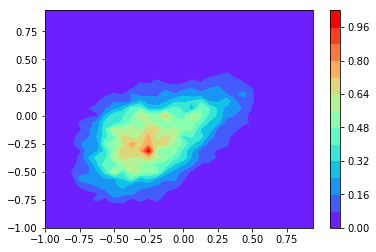

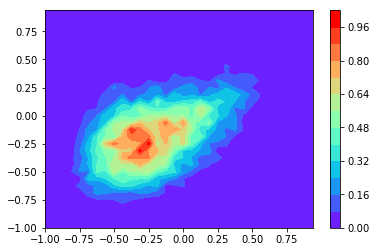

[3/101][99/100] Loss_G: -0.7398 D(G(z)): 0.7398


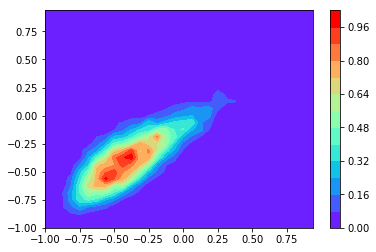

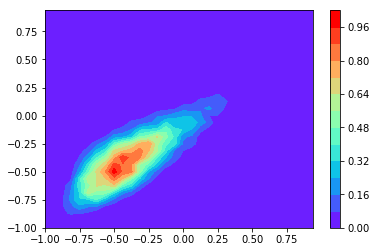

[4/101][99/100] Loss_G: -0.7951 D(G(z)): 0.7951


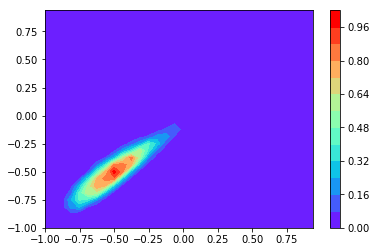

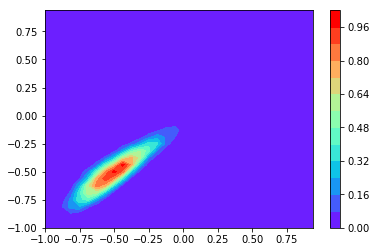

[5/101][99/100] Loss_G: -0.8121 D(G(z)): 0.8121


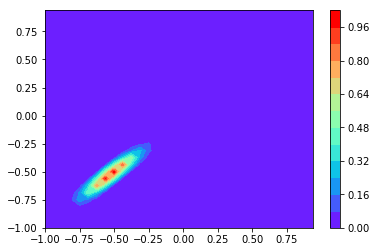

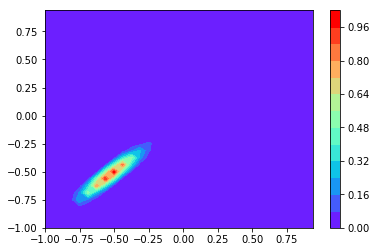

[6/101][99/100] Loss_G: -0.8195 D(G(z)): 0.8195


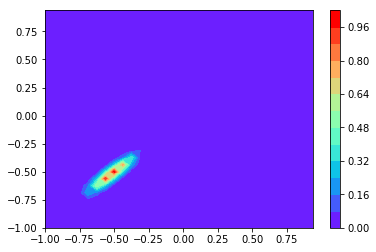

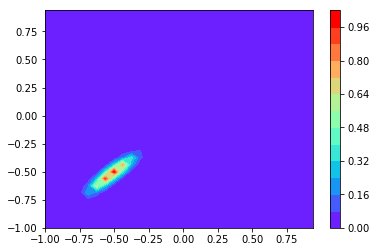

[7/101][99/100] Loss_G: -0.8263 D(G(z)): 0.8263


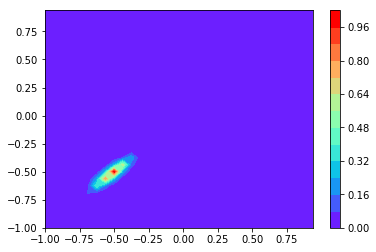

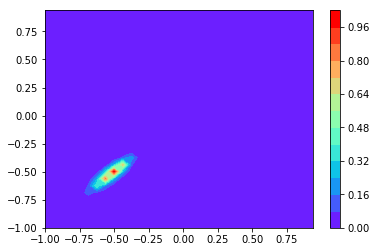

[8/101][99/100] Loss_G: -0.8290 D(G(z)): 0.8290


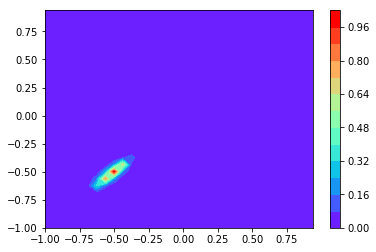

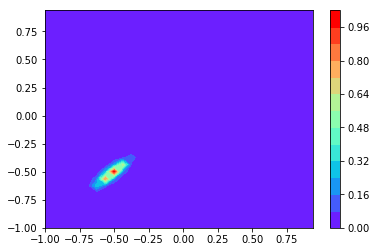

[9/101][99/100] Loss_G: -0.8297 D(G(z)): 0.8297


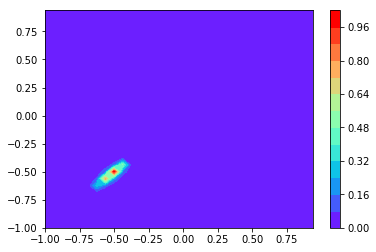

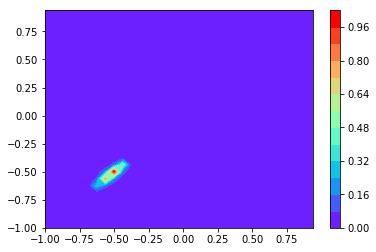

[10/101][99/100] Loss_G: -0.8326 D(G(z)): 0.8326


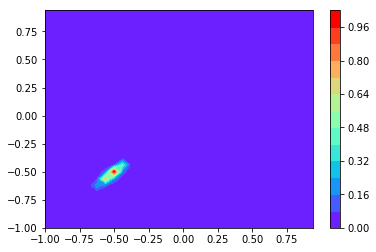

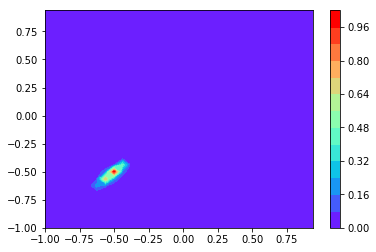

[11/101][99/100] Loss_G: -0.8351 D(G(z)): 0.8351


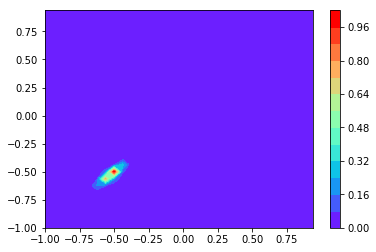

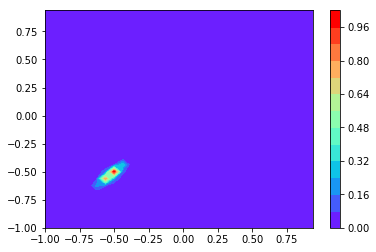

[12/101][99/100] Loss_G: -0.8384 D(G(z)): 0.8384


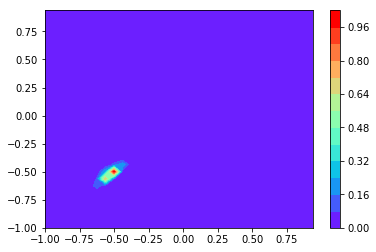

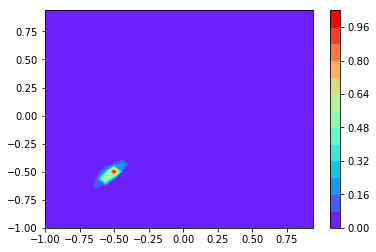

[13/101][99/100] Loss_G: -0.8376 D(G(z)): 0.8376


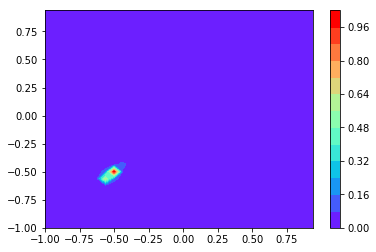

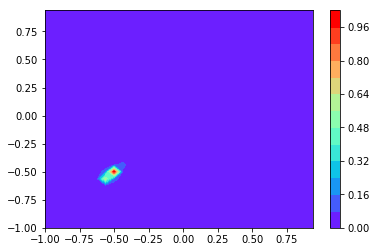

[14/101][99/100] Loss_G: -0.8383 D(G(z)): 0.8383


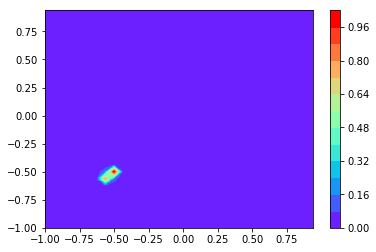

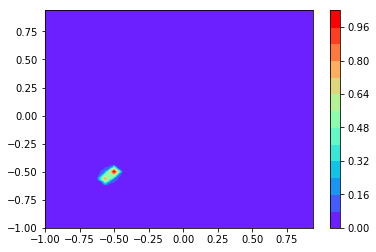

[15/101][99/100] Loss_G: -0.8408 D(G(z)): 0.8408


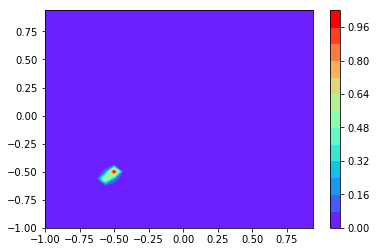

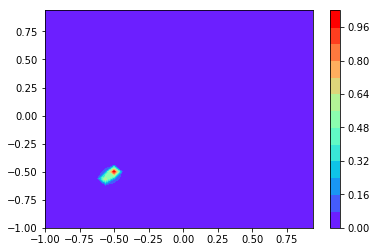

[16/101][99/100] Loss_G: -0.8416 D(G(z)): 0.8416


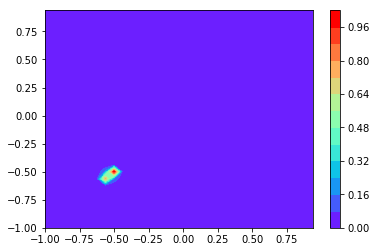

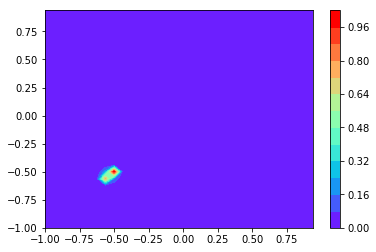

[17/101][99/100] Loss_G: -0.8426 D(G(z)): 0.8426


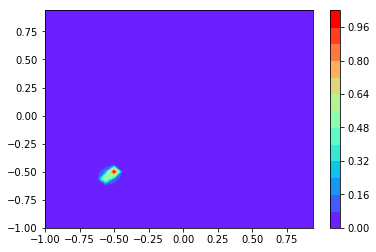

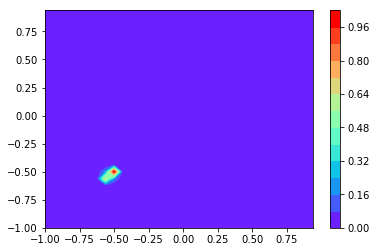

[18/101][99/100] Loss_G: -0.8442 D(G(z)): 0.8442


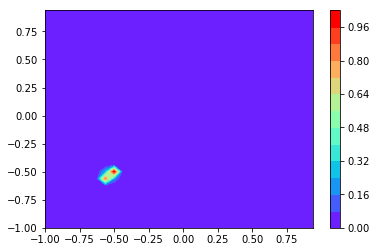

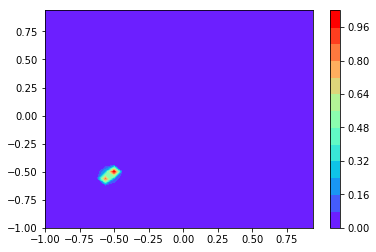

[19/101][99/100] Loss_G: -0.8440 D(G(z)): 0.8440


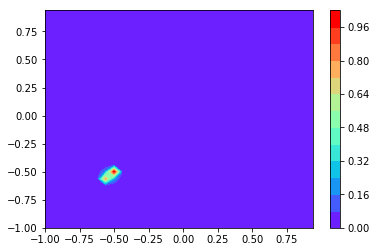

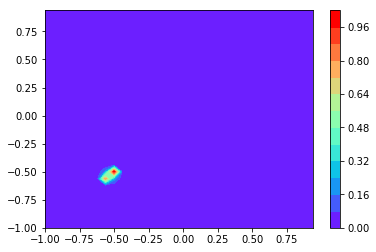

[20/101][99/100] Loss_G: -0.8444 D(G(z)): 0.8444


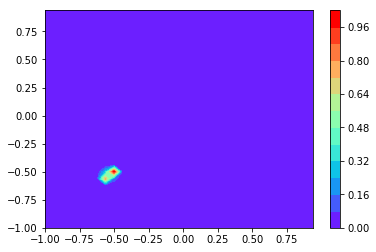

KeyboardInterrupt: 

In [64]:
for epoch in range(niter):
    GMutils.plot_heat_map(utils.sample_G(netG, nz, 10000))
    for i in range(nElements):
        ############################
        # (2) Update G network
        ###########################  
        netG.zero_grad()
        label.data.fill_(real_label) # fake labels are real for generator cost
        noise.data.normal_(0, 1)
        fake = netG(noise)
        output = netD(fake)
        errG = - torch.mean(output)
        errG.backward()
        
        D_G_z2 = output.data.mean()
        
        optimizerG.step()
        
    print('[%d/%d][%d/%d] Loss_G: %.4f D(G(z)): %.4f'
              % (epoch, niter + 1, i, nElements, errG.data[0], D_G_z2))        
    GMutils.plot_heat_map(utils.sample_G(netG, nz, 10000))

[0/101][999/1000] Loss_D: -0.20894349 Loss_G: -0.9553 D(G(z)): 0.9549


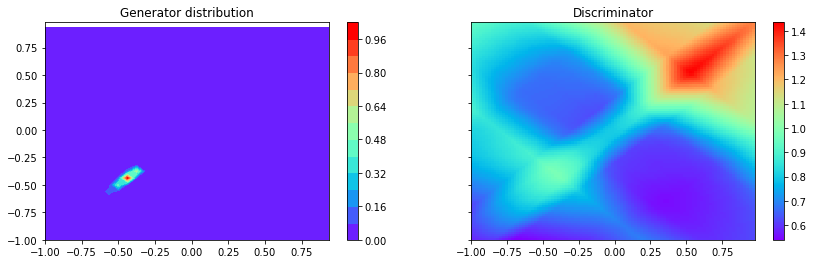

[1/101][999/1000] Loss_D: -0.70607978 Loss_G: -0.9677 D(G(z)): 0.9677


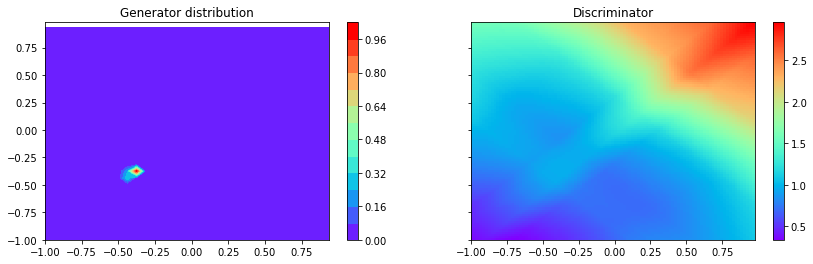

[2/101][999/1000] Loss_D: 0.80006409 Loss_G: -2.7061 D(G(z)): 2.6570


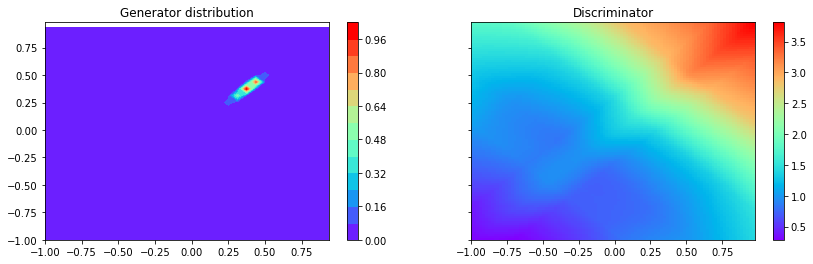

[3/101][999/1000] Loss_D: -0.87719798 Loss_G: -0.9842 D(G(z)): 0.9842


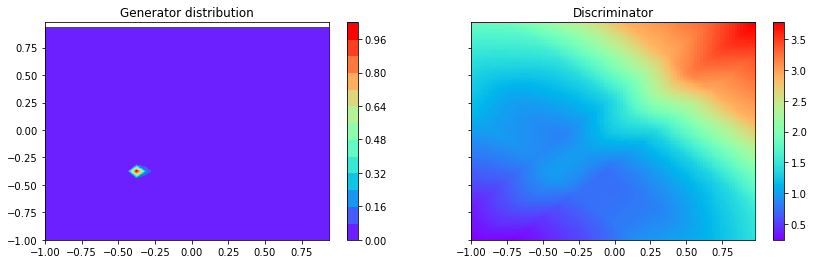

[4/101][999/1000] Loss_D: -0.90623772 Loss_G: -1.1729 D(G(z)): 1.1728


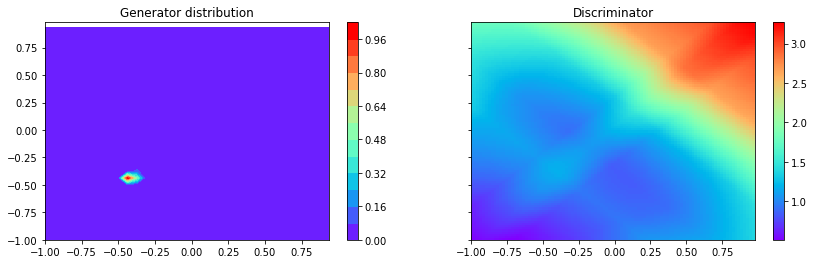

[5/101][999/1000] Loss_D: -0.35188079 Loss_G: -1.3969 D(G(z)): 1.3966


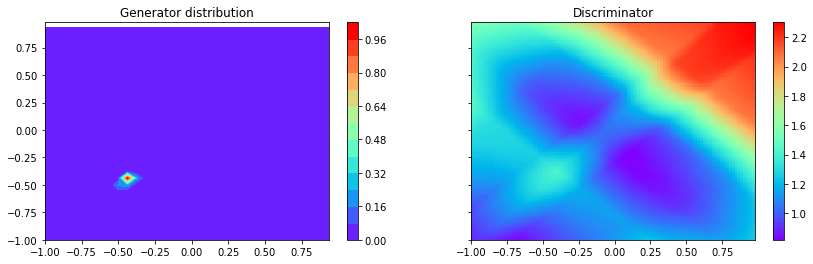

[6/101][999/1000] Loss_D: -0.02281606 Loss_G: -1.6041 D(G(z)): 1.6022


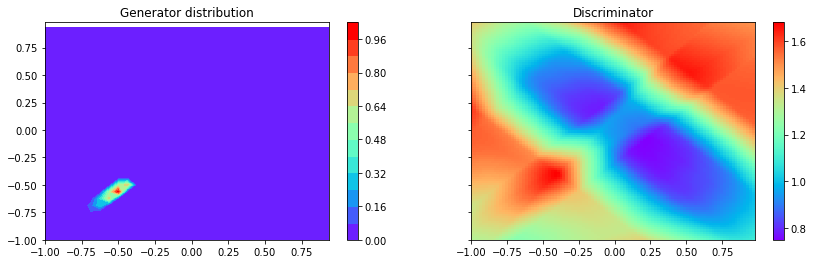

[7/101][999/1000] Loss_D: 0.45061266 Loss_G: -1.9025 D(G(z)): 1.9023


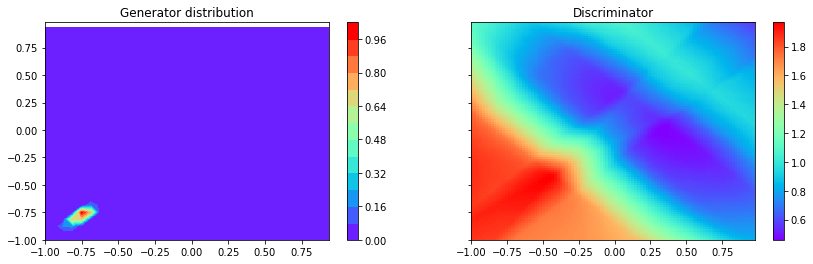

[8/101][999/1000] Loss_D: 1.60577595 Loss_G: -2.9240 D(G(z)): 2.9214


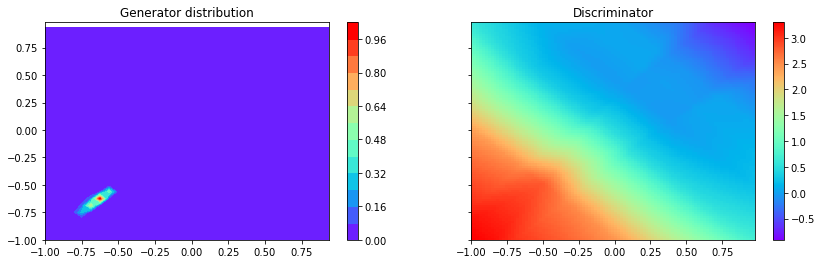

[9/101][999/1000] Loss_D: -1.01475954 Loss_G: -0.0299 D(G(z)): 0.0299


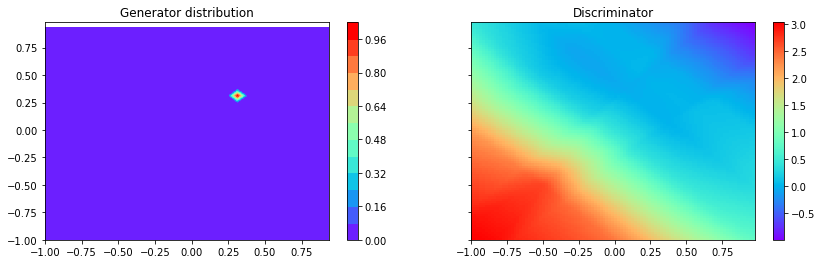

[10/101][999/1000] Loss_D: -0.78539973 Loss_G: -0.3076 D(G(z)): 0.3076


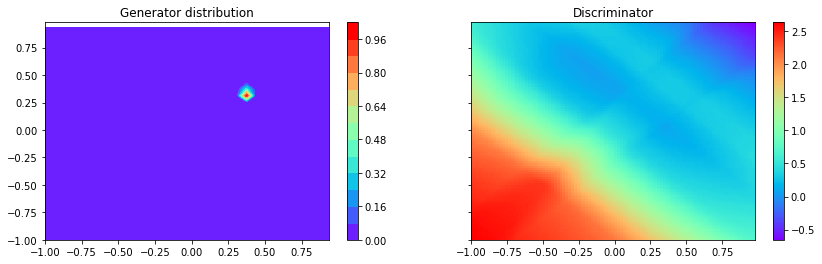

[11/101][999/1000] Loss_D: -0.55300128 Loss_G: -0.8033 D(G(z)): 0.8032


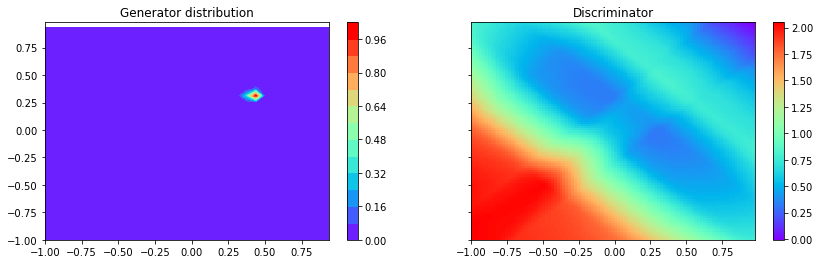

[12/101][999/1000] Loss_D: -0.17926717 Loss_G: -1.3788 D(G(z)): 1.3766


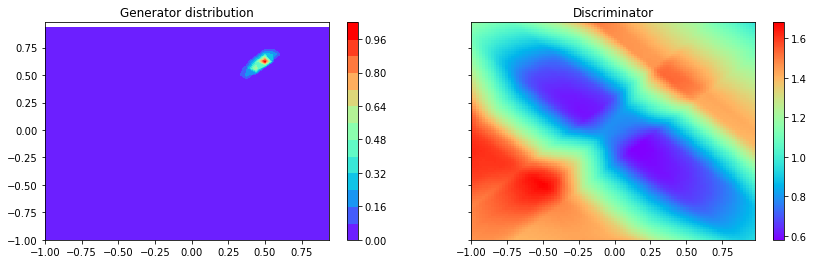

[13/101][999/1000] Loss_D: 1.46142411 Loss_G: -3.4616 D(G(z)): 3.4599


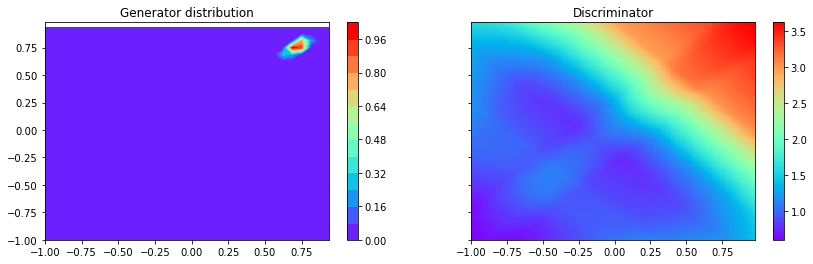

[14/101][999/1000] Loss_D: -1.07353818 Loss_G: -1.1276 D(G(z)): 1.1276


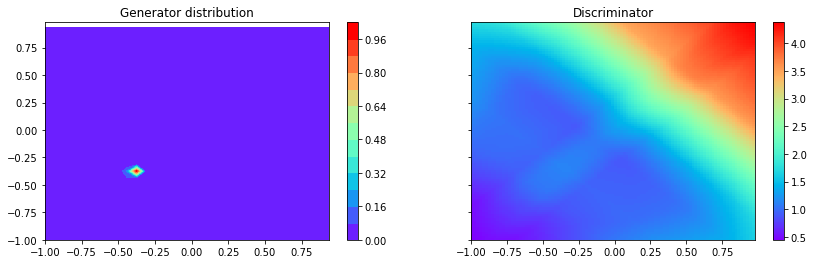

[15/101][999/1000] Loss_D: -0.69811344 Loss_G: -1.3231 D(G(z)): 1.3231


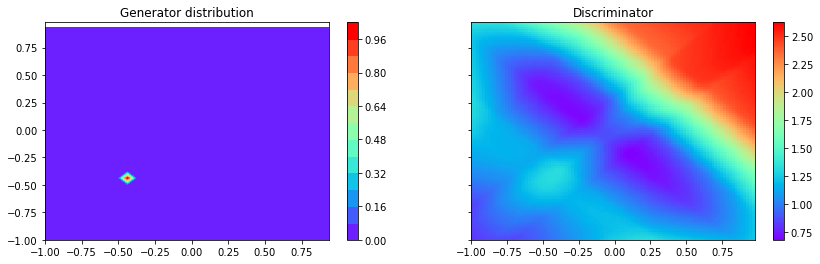

[16/101][999/1000] Loss_D: 0.11822510 Loss_G: -1.7468 D(G(z)): 1.7462


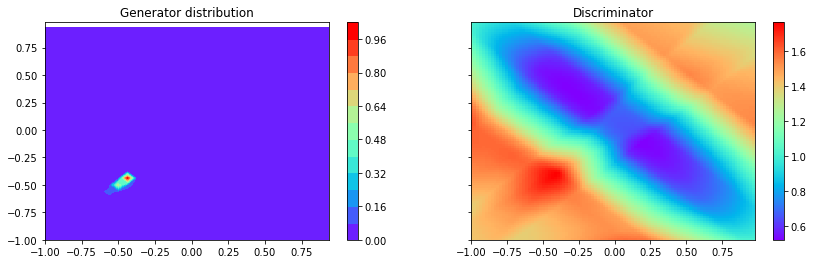

[17/101][999/1000] Loss_D: 1.23264718 Loss_G: -2.4549 D(G(z)): 2.4547


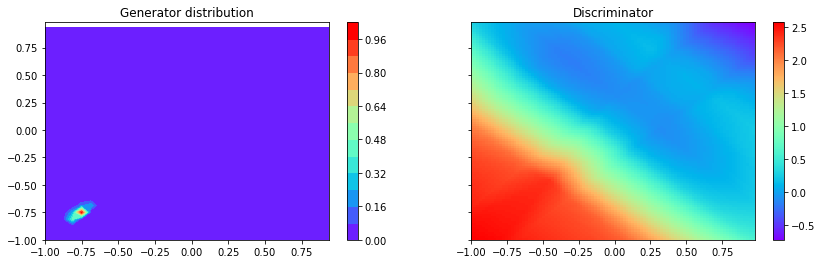

[18/101][999/1000] Loss_D: -1.54665112 Loss_G: 0.5037 D(G(z)): -0.5037


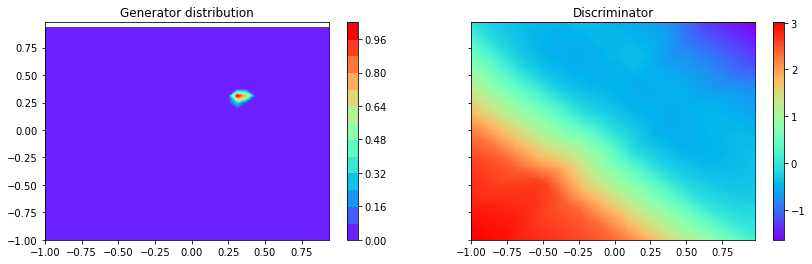

[19/101][999/1000] Loss_D: -1.00319278 Loss_G: -0.2595 D(G(z)): 0.2595


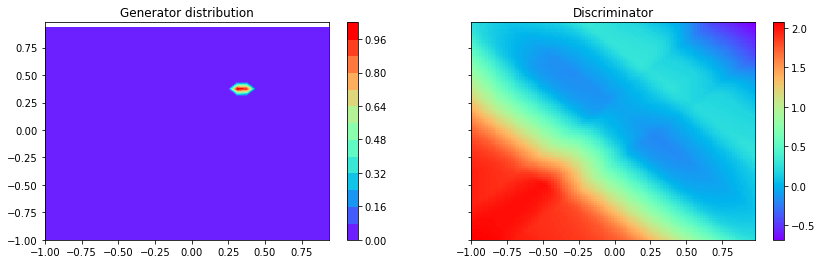

[20/101][999/1000] Loss_D: -0.22091293 Loss_G: -1.1117 D(G(z)): 1.1115


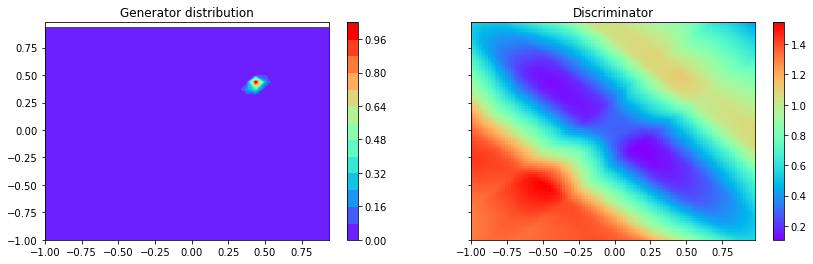

[21/101][999/1000] Loss_D: 0.97202730 Loss_G: -2.7078 D(G(z)): 2.7077


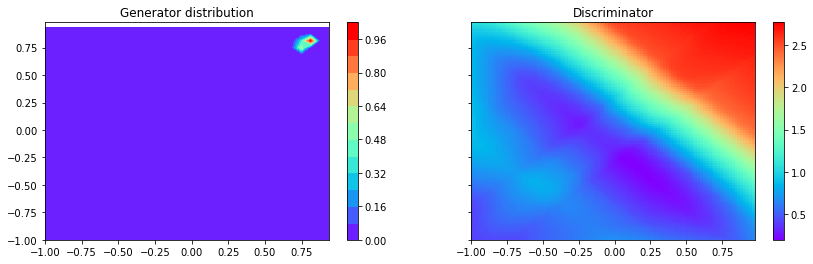

[22/101][999/1000] Loss_D: -1.36194527 Loss_G: -0.5443 D(G(z)): 0.5443


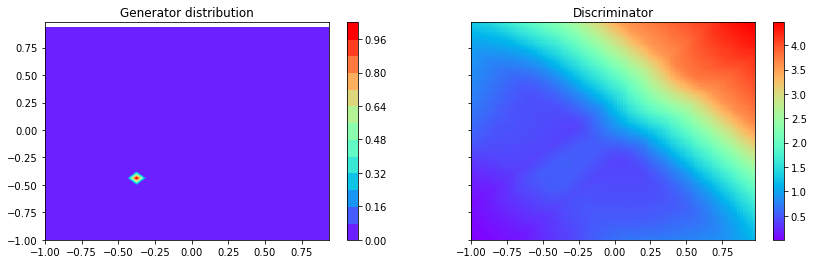

[23/101][999/1000] Loss_D: -0.88701266 Loss_G: -0.9718 D(G(z)): 0.9718


KeyboardInterrupt: 

In [77]:
n_critic = 1
print_every = nElements / 10
for epoch in range(niter):
    for i in range(nElements):
        ############################
        # (1) Update D network
        ###########################
        # train with real
        for t in range(n_critic):
            netD.zero_grad()
            
            ## Real 
            real_cpu = GMutils.sample(batchSize)
            batch_size = real_cpu.size(0)
            input.data.resize_(real_cpu.size()).copy_(real_cpu)
            
            output_real = netD(input)
            
            ## Fake
            noise.data.resize_(batch_size, nz)
            noise.data.normal_(0, 1)
            fake = netG(noise).detach()
            
            output_fake = netD(fake)
            
            errD = - torch.mean(output_real) + torch.mean(output_fake)
            errD.backward()
            optimizerD.step()
                        
            ## Clip
            for p in netD.parameters():
                p.data.clamp_(-c, c)

        ############################
        # (2) Update G network
        ###########################
        
        netG.zero_grad()
        label.data.fill_(real_label) # fake labels are real for generator cost
        noise.data.normal_(0, 1)
        fake = netG(noise)
        output = netD(fake)
        errG = - torch.mean(output) - output.data.var()
        errG.backward()
        
        D_G_z2 = output.data.mean()
        
        optimizerG.step()
        
    print('[%d/%d][%d/%d] Loss_D: %.8f Loss_G: %.4f D(G(z)): %.4f'
              % (epoch, niter + 1, i, nElements,
                 errD.data.sum(), errG.data[0], D_G_z2))
            
    GMutils.plot_duo_heat_map(utils.sample_G(netG, nz, 10000), netD)